In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist
import tensorflow as tf

from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.6.0


# Import Dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 2)

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
train_labels = to_categorical(train_labels, dtype ="uint8")
val_labels = to_categorical(val_labels, dtype ="uint8")
test_labels = to_categorical(test_labels, dtype ="uint8")

In [4]:
train_images = train_images.reshape(-1,28,28,1)
val_images = val_images.reshape(-1,28,28,1)
test_images = test_images.reshape(-1,28,28,1)

In [5]:
def intensity_scaling(train_images):
  return np.array(255*(train_images/255)**2,dtype='uint8')
train_images = intensity_scaling(train_images)

# Build Model

In [6]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(28,28,1),activation='relu'))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(28,28,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),input_shape=(28,28,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10,activation='softmax'))

In [7]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Model Train

In [8]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'auto', verbose = 0)
reduce_lr =  ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.0001)
model_modified = model.fit(train_images, train_labels, validation_data=(val_images,val_labels), batch_size=64, epochs=50 ,callbacks=[early_stopping, reduce_lr] )

Epoch 1/50
750/750 [==============================] - 39s 15ms/step - loss: 0.6867 - accuracy: 0.7846 - val_loss: 0.3819 - val_accuracy: 0.8506
Epoch 2/50
750/750 [==============================] - 11s 15ms/step - loss: 0.3824 - accuracy: 0.8636 - val_loss: 0.3054 - val_accuracy: 0.8867
Epoch 3/50
750/750 [==============================] - 11s 15ms/step - loss: 0.3210 - accuracy: 0.8840 - val_loss: 0.2838 - val_accuracy: 0.8969
Epoch 4/50
750/750 [==============================] - 11s 15ms/step - loss: 0.2809 - accuracy: 0.8979 - val_loss: 0.2805 - val_accuracy: 0.8972
Epoch 5/50
750/750 [==============================] - 11s 15ms/step - loss: 0.2558 - accuracy: 0.9063 - val_loss: 0.2707 - val_accuracy: 0.9013
Epoch 6/50
750/750 [==============================] - 11s 15ms/step - loss: 0.2325 - accuracy: 0.9145 - val_loss: 0.2741 - val_accuracy: 0.9024
Epoch 7/50
750/750 [==============================] - 11s 15ms/step - loss: 0.2157 - accuracy: 0.9203 - val_loss: 0.2768 - val_accuracy:

# Save the model

In [9]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 228
drwxr-xr-x 2 root root   4096 Sep 13 14:22 assets
-rw-r--r-- 1 root root  21665 Sep 13 14:22 keras_metadata.pb
-rw-r--r-- 1 root root 198904 Sep 13 14:22 saved_model.pb
drwxr-xr-x 2 root root   4096 Sep 13 14:22 variables


In [10]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0913 14:22:16.989933 140420031027072 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pyt

In [11]:
import sys

if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [12]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  14426      0 --:--:-- --:--:-- --:--:-- 14356
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Re

In [13]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 77 not upgraded.
Need to get 347 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.6.0 [347 MB]
Fetched 347 MB in 5s (63.1 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 148492 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.6.0_all.deb ...
Unpacking tensorflow-model-server (2.6.0) ...
Setting up tensorflow-model-server (2.6.0) ...


# Running Tensorflow Serving

In [14]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [15]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=CNN_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [16]:
!tail server.log

2021-09-13 14:22:42.000283: I tensorflow_serving/model_servers/server_core.cc:465] Adding/updating models.
2021-09-13 14:22:42.000315: I tensorflow_serving/model_servers/server_core.cc:591]  (Re-)adding model: CNN_model
2021-09-13 14:22:42.002728: I tensorflow_serving/core/basic_manager.cc:740] Successfully reserved resources to load servable {name: CNN_model version: 1}
2021-09-13 14:22:42.002765: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: CNN_model version: 1}
2021-09-13 14:22:42.002785: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: CNN_model version: 1}
2021-09-13 14:22:42.002858: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: /tmp/1
2021-09-13 14:22:42.007670: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-09-13 14:22:42.007707: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:132] R

# Make requests to the model

In [17]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images.tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]]]}


In [18]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

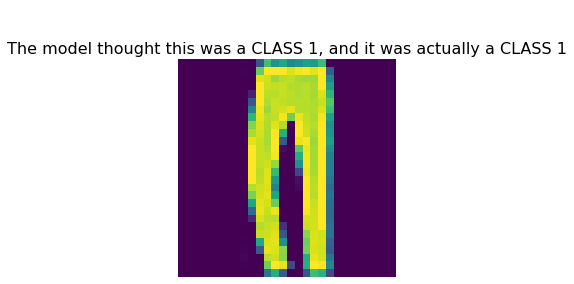

In [28]:
!pip install -q requests

import requests

headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/CNN_model:predict', data=data, headers=headers)
predictions = np.array(json.loads(json_response.text)['predictions'])

show(2, 'The model thought this was a CLASS {}, and it was actually a CLASS {}'.format(
  np.argmax(predictions[2]), np.argmax(test_labels[2])))

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
def evaluation(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    return cm, accuracy_score(y_test, y_pred)

In [37]:
conf_mat, accuracy = evaluation(np.argmax(test_labels,axis=1 ),np.argmax(predictions,axis=1 ))
print("Confusion Matrix \n", conf_mat)
print("\n\nAccuracy: ",accuracy)

Confusion Matrix 
 [[881   0  14   8   3   0  84   0  10   0]
 [  3 975   0   9   3   0   5   0   5   0]
 [ 35   0 819   6  27   0 111   0   2   0]
 [ 48   0   9 870  32   0  39   0   2   0]
 [  2   0  83  19 811   0  79   0   6   0]
 [  0   0   0   0   0 959   0  23   4  14]
 [127   0  44  17  64   0 724   0  24   0]
 [  0   0   0   0   0   4   0 959   1  36]
 [  7   0   2   3   0   0   3   1 984   0]
 [  0   0   1   0   0   2   1  28   1 967]]


Accuracy:  0.8949
